# Wheel turning speed time series analysis

**THESE ARE ROUGH NOTES - NEED IMPROVING**

In the experiment, the response of the animal is recorded through the turning speed of a steering wheel. 

This notebook is a guide for how to analyse this data.

* Section 1 - loading the datafile and converting data to easily workable format

* Section 2 - visualising data at various levels (individual trials and all trials together)

* Section 3 - determining a response from the wheel speed data (turning direction)

* Section 4 - validating results against Steinmetz et al. 

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## 1) Loading dataset

**Libraries Used:**

- **xarray:** 
  - `xr.load_dataset()`: Loads a dataset from a specified file path using the xarray library. It facilitates data manipulation and analysis of multi-dimensional arrays.
  - `to_dataframe()`: Converts the loaded xarray dataset into a Pandas DataFrame for easier data manipulation and analysis.
 
- **Pandas:**
    - `df.reset_index()`: reset the index of a dataframe.
    - `df.groupby('grouping_variable')`: split a dataframe into chunks according to a `grouping_variable`
    - `df.DataFrame({'col1':col1_values, 'col2':col2_values}`: create a dataframe from a dictionary of data columns

In [4]:
dataset = xr.load_dataset('/home/sangeetha/Work/Germany/bootcamp/data/steinmetz_neuromatch_dataset/steinmetz_2016-12-14_Cori.nc')
dataset

<xarray.Dataset>
Dimensions:             (trial: 364, time: 250, cell: 734,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 7, spike_id: 2446173)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 359 360 361 362 363 364
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 729 730 731 732 733 734
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'ACA' 'LS' ... 'SUB' 'VISp'
  * spike_id            (spike_id) int32 1 2 3 4 ... 2446171 2446172 2446173
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 100 0 100 0 50 0 0 ... 0 100 50 50 0 25 100
    contrast_right      (trial) int8 0 50 50 0 100 0 0 ... 25 100 25 25 50 0 100
    gocue               (trial) float64 1.027 0.8744 0.8252 ... nan nan nan
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 1.0 1.0 1.0 -1.0 ... nan nan nan nan
    feedback_time       (trial) float64 1.187 1.438 0.986 2.296 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... -0...
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... 0.0
    lfp                 (brain_area_lfp, trial, time) float64 -2.851 ... 5.571
    spike_time          (spike_id) float32 0.2676 2.308 0.8535 ... 2.189 2.399
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 734 734 734 734 734
    spike_trial         (spike_id) uint32 21 21 31 37 43 ... 364 364 364 364 364
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

In [1]:
# drop nans from dataframe!
# THIS SHOULD BE DONE IN DATA PREPROCESSING! NOT AN EXERCISE FOR THE STUDENTS
# dataset = dataset.where(dataset.active_trials==1 , drop=True)

**Exercises**

Convert the wheel speed data into a Pandas DataFrame 

In [5]:
wheel_data = dataset['wheel'].to_dataframe()

wheel_data

wheel
trial time       
1     0.01     -1
      0.02      0
      0.03      0
      0.04      0
      0.05      0
...           ...
364   2.46      0
      2.47      0
      2.48      0
      2.49      0
      2.50      0

[91000 rows x 1 columns]

Add a column to the dataframe that gives a unique identifier for every datapoint

In [6]:
wheel_data['data_id'] = range(0, len(wheel_data))

wheel_data

wheel  data_id
trial time                
1     0.01     -1        0
      0.02      0        1
      0.03      0        2
      0.04      0        3
      0.05      0        4
...           ...      ...
364   2.46      0    90995
      2.47      0    90996
      2.48      0    90997
      2.49      0    90998
      2.50      0    90999

[91000 rows x 2 columns]

Reset the index of the DataFrame and name the result `df`

In [7]:
df = wheel_data.reset_index()

df

,trial,time,wheel,data_id
0,1,0.01,-1,0
1,1,0.02,0,1
2,1,0.03,0,2
3,1,0.04,0,3
4,1,0.05,0,4
...,...,...,...,...
90995,364,2.46,0,90995
90996,364,2.47,0,90996
90997,364,2.48,0,90997
90998,364,2.49,0,90998


Notice how the structure of the DataFrame changed! After reset_index(), the index of the row matches the data_id giving each row a unique id

### Manipulate data into a convenient format

The above dataframe contains datapoints for all trials on a given session date. This is not the most convenient format, as it does not allow for easy separation of trials. 

A better format is a dataframe with each column representing a trial and the rows representing the time bin.

Make a list of arrays of wheel speed for each trial and a list of trial numbers.

In [12]:
wheel_list = [group.wheel.values for group_name, group in wheel_data.groupby("trial")]
trial_list = [group_name for group_name, group in wheel_data.groupby("trial")]

Use these arrays to produce a dataframe where each column represents a trial an the time bins are given by the index.

Call this dataframe `wheel_df`

In [13]:
wheel_df = pd.DataFrame({trial_list[i]: wheel_list[i] for i in range(len(trial_list))})
wheel_df.index.name = 'time_bin'
wheel_df

,1,2,3,4,5,6,7,8,9,10,...,355,356,357,358,359,360,361,362,363,364
time_bin,,,,,,,,,,,,,,,,,,,,,
0,-1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,-1,0,0,-1,0,0,1,0,...,0,0,0,1,-1,0,0,0,0,0
3,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,-7,1,0,0,0,0,...,0,0,0,-1,0,0,0,1,0,0
246,0,0,0,0,-6,2,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
247,1,1,-1,0,-6,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
## Extra homework line

## Recreate the same table with pivot_table

df['time_bin'] = df['time']*100
df['time_bin'] = df['time_bin'].astype('int')
ddf = df.pivot_table(index='time_bin', columns='trial', values='wheel')
ddf.columns.name = None
ddf.astype('int')

,1,2,3,4,5,6,7,8,9,10,...,355,356,357,358,359,360,361,362,363,364
time_bin,,,,,,,,,,,,,,,,,,,,,
1,-1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,-1,0,0,-1,0,0,1,0,...,0,0,0,1,-1,0,0,0,0,0
4,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0,0,0,0,-7,1,0,0,0,0,...,0,0,0,-1,0,0,0,1,0,0
247,0,0,0,0,-6,2,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
248,1,1,-1,0,-6,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2) Data visualisation

**Libraries Used:**
- **Pandas:**
    - `df['time']`: accessing individual columns
- **matplotlib:**
  - `plt.plot()`: Plot data on the current axes.
  - `plt.xlabel()`: Set the x-axis label for the current axes.
  - `plt.ylabel()`: Set the y-axis label for the current axes.
  - `plt.legend()`: Show the legend labels for the current axes.

**Exercises**

Select the wheel speed data from a single trial

In [92]:
selected_data = wheel_df[5]
selected_data

time_bin
0      0
1      0
2      0
3      0
4      0
      ..
245   -7
246   -6
247   -6
248   -4
249   -3
Name: 5, Length: 250, dtype: int8

Plot the wheel speed against time for the single selected trial

Text(0, 0.5, 'wheel speed/arb. units')

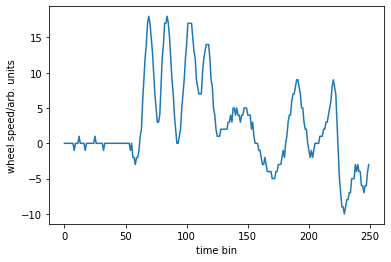

In [93]:
plt.plot(selected_data)
plt.xlabel('time bin')
plt.ylabel('wheel speed/arb. units')

Plot wheel speed against time for multiple trials

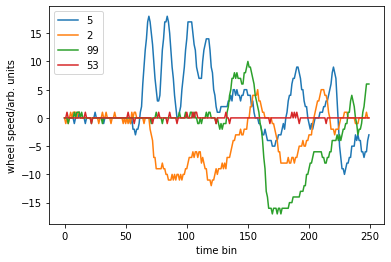

In [94]:
wanted_trials = [5,2,99,53]
selected_data = wheel_df[wanted_trials]

plt.plot(selected_data, label=wanted_trials)
plt.xlabel('time bin')
plt.ylabel('wheel speed/arb. units')
plt.legend()

Make a plot that shows the wheel speeds for all trials 

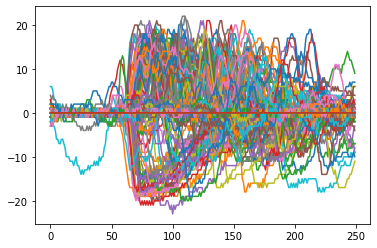

In [95]:
plt.plot(wheel_df);

Looks overplotted! Let's do better (possible homework exercise!!)

We can make a plot, known as a heatmap, where each pixel tells us how many datapoints occupy that region. This allows us to plot a large number of trials at once, while still being able to see the contributions of individual trials.


Look at the range and type of values that the wheel speed data and time bin data have. We will use this information to define bins in the x and y directions. 

In [96]:
# range of wheel speed data - many ways to do this!
print(wheel_df.values.min(), wheel_df.values.max())

-23 22


In [98]:
# look at unique values of wheel speed
print(np.unique(wheel_df))

[-23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6
  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12
  13  14  15  16  17  18  19  20  21  22]


In [97]:
# look at unique values of time index
print(np.unique(wheel_df.index))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Now define reasonable bins in the x and y directions for the heatmap

In [99]:
x_bins = wheel_df.index.values
y_bins = np.arange(wheel_df.min(axis=None), wheel_df.max(axis=None),1)

From the bins, set up an empty matrix that will store the values for the heatmap. Call this matrix `heatmap_matrix`

In [100]:
heatmap_matrix = np.zeros([ len(y_bins[:-1]),len(x_bins[:-1])])

The `histogram2d` function from `numpy` counts the number of points lying in the specified bins when given the x and y values of the points.

Use this function on one colum of the dataframe `wheel_df`. Store the resulting matrix in a variable called `h`

In [101]:
h,xx,yy = np.histogram2d(wheel_df[1],wheel_df.index.values, bins=[ y_bins,x_bins])

Visualise `h` with matplotlib's `imshow` function

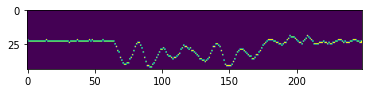

In [102]:
plt.imshow(h)

Now do the same for every column of `wheel_df`, summing the result to `heatmap_matrix`

In [103]:
for i, col in wheel_df.items():
    h,xx,yy = np.histogram2d(col,wheel_df.index.values, bins=[ y_bins,x_bins])
    heatmap_matrix += h


Visualise `heatmap_matrix`. Hint- you may find it useful to use a logarithmic colourscale. Investigate the `norm` argument of `imshow` for this.

Text(0, 0.5, 'wheel speed/arb. units')

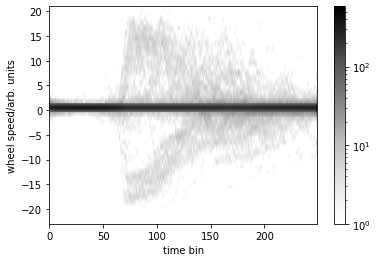

In [104]:
im = plt.imshow(heatmap_matrix, 
                norm=LogNorm(), 
                cmap=plt.cm.Greys,
                interpolation='bilinear',
                aspect='auto',
                origin="lower",
                extent=[min(x_bins),max(x_bins),min(y_bins),max(y_bins)] )
plt.colorbar(im)

plt.xlabel("time bin")
plt.ylabel("wheel speed/arb. units")

### All together in one cell 

Text(0, 0.5, 'wheel speed/arb. units')

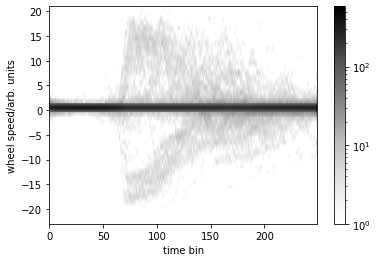

In [105]:
y_bins = np.arange(wheel_df.min(axis=None), wheel_df.max(axis=None),1)
x_bins= wheel_df.index.values

heatmap_matrix = np.zeros([ len(y_bins[:-1]),len(x_bins[:-1])])

for i, col in wheel_df.items():
    h,xx,yy = np.histogram2d(col,wheel_df.index.values, bins=[ y_bins,x_bins])
    heatmap_matrix += h

im = plt.imshow(heatmap_matrix, 
                norm=LogNorm(), 
                cmap=plt.cm.Greys,
                interpolation='bilinear',
                aspect='auto',
                origin="lower",
                extent=[min(x_bins),max(x_bins),min(y_bins),max(y_bins)] )
plt.colorbar(im)

plt.xlabel("time bin")
plt.ylabel("wheel speed/arb. units")

## 3) Determining Turning Direction

**Libraries Used:**


- **Pandas:**
    - `df.mean()`: reset the index of a dataframe.
    - `df[df['col1'] >10]`: index filtering based on a condition

**Exercises**

Make a dataframe containing the mean wheel speed for each trial

In [116]:
mean_wheel_speeds = wheel_df.mean()

mean_df = pd.DataFrame({'mean_speed':mean_wheel_speeds, 'trial': mean_wheel_speeds.index})

mean_df

,mean_speed,trial
1,4.376,1
2,-2.944,2
3,2.616,3
4,-0.268,4
5,2.532,5
...,...,...
360,-0.004,360
361,0.000,361
362,-0.004,362
363,0.000,363


Use `mean_df` and `wheel_df` to make a plot of wheel speeds where the mean speed was greater than 0

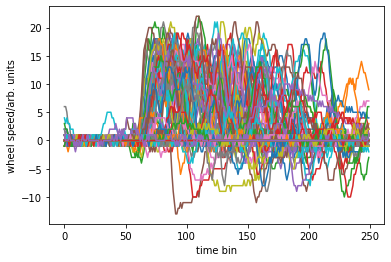

In [117]:
selected_trials = mean_df[mean_df['mean_speed'] > 0]

selected_data = wheel_df[selected_trials['trial']]

plt.plot(selected_data)
plt.xlabel('time bin')
plt.ylabel('wheel speed/arb. units')
plt.show()

## 4 Result Validation

**Libraries Used:**

- **Python:**
    - `print()`: print information to the console 

- **Pandas:**
    - `df['col'].isin(values)`: find rows of dataframe where datapoints are contained in a list of values
 
- **matplotlib:**
    - `plt.scatter()`: make a scatter plot
    - `plt.scatter(color='some color', marker='some marker')`: change marker properties of scatter plot

Get response types from Steinmetz data

In [119]:
response_df = dataset.response_type.to_dataframe()
response_df.reset_index(inplace=True)

Find trials where `response_type` is 1 (that means wheel was turned to the right, ie. with a positive speed)

In [120]:
steinmetz_trials = response_df[response_df.response_type==1]['trial']

Find trials where mean speed was positive and response recorded by Steinmetz was 1


In [121]:
trials_with_positive_mean_speed_and_response_1 = mean_df[(mean_df['mean_speed'] > 0) & (mean_df['trial'].isin(steinmetz_trials))]

Assess quantitatively the agreement between the recorded responses in the dataset and the response obtained from the mean speed

In [122]:
print('number of trials with response_type==1: ', len(steinmetz_trials))
print('number of trials with positive mean speed: ', len(mean_df[(mean_df['mean_speed'] > 0) ]))
print('number of trials with positive mean speed and response_type==1: ', len(trials_with_positive_mean_speed_and_response_1))

number of trials with response_type==1:  71
number of trials with positive mean speed:  155
number of trials with positive mean speed and response_type==1:  67


Make a scatter plot of trial number against mean wheel speed for trials with positive mean speed

Text(0, 0.5, 'mean wheel speed')

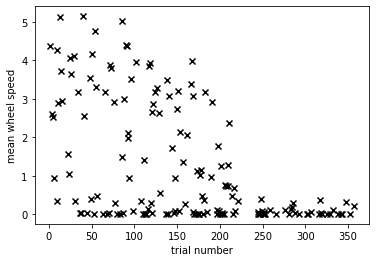

In [123]:
plt.scatter(mean_df[mean_df['mean_speed'] > 0]['trial'] ,mean_df[mean_df['mean_speed'] > 0]['mean_speed'], color='k', marker='x')

plt.xlabel('trial number')
plt.ylabel('mean wheel speed')

Include on the same plot the trials where mean wheel speed is positive and the response recorded by Steinmetz is 1. 

Use a different marker types to distinguish between the data

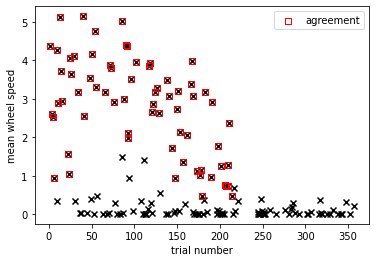

In [124]:
plt.scatter(mean_df[mean_df['mean_speed'] > 0]['trial'] ,mean_df[mean_df['mean_speed'] > 0]['mean_speed'], color='k', marker='x')

plt.scatter(trials_with_positive_mean_speed_and_response_1['trial'], 
            trials_with_positive_mean_speed_and_response_1['mean_speed'], 
            marker='s',
            color='r',
            facecolor='none', label='agreement')


plt.xlabel('trial number')
plt.ylabel('mean wheel speed')
plt.legend()